- recent update: 24.10.29
- update content:
    1. mid-price 생성
    2. significant or insignificant 예측 모델 생성
    3. significant 예측되는 경우에만 significant increase or decrease인지 예측
- target var: mid price return significant change (0 or 1)
- Model: XGBoost(significant or insignificant 예측) + LSTM(significant increase or decrease 예측)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
#from optuna.integration import XGBoostPruningCallback
#import optuna

In [ ]:
# display max
#pd.set_option('display.max_rows', 90)
#pd.set_option('display.max_column', None)

In [ ]:
df_origin = pd.read_csv('/content/drive/MyDrive/eunsung/data/df_processed_month3_1m5m_maxreturn.csv')

In [ ]:
# 시간 타입으로 변경
df_origin['false.2'] = pd.to_datetime(df_origin['false.2'])

# 데이터프레임 리샘플링 - 'timestamp_column'을 타임스탬프 컬럼 이름으로 변경하세요
df_origin.set_index('false.2', inplace=True)  # 타임스탬프를 인덱스로 설정
df = df_origin.resample('10S').mean()  # 1초 단위로 묶어서 평균값 계산

# 결과 확인
df.head(20)
print(df.shape)

df.reset_index(inplace=True)

<ipython-input-5-adb55d3fcb1c>:6: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df_origin.resample('10S').mean()  # 1초 단위로 묶어서 평균값 계산


(43200, 86)


In [ ]:
df.columns

Index(['false.2', 'ask_price_1', 'ask_price_10', 'ask_price_11',
       'ask_price_12', 'ask_price_13', 'ask_price_14', 'ask_price_15',
       'ask_price_2', 'ask_price_3', 'ask_price_4', 'ask_price_5',
       'ask_price_6', 'ask_price_7', 'ask_price_8', 'ask_price_9',
       'ask_size_1', 'ask_size_10', 'ask_size_11', 'ask_size_12',
       'ask_size_13', 'ask_size_14', 'ask_size_15', 'ask_size_2', 'ask_size_3',
       'ask_size_4', 'ask_size_5', 'ask_size_6', 'ask_size_7', 'ask_size_8',
       'ask_size_9', 'bid_price_1', 'bid_price_10', 'bid_price_11',
       'bid_price_12', 'bid_price_13', 'bid_price_14', 'bid_price_15',
       'bid_price_2', 'bid_price_3', 'bid_price_4', 'bid_price_5',
       'bid_price_6', 'bid_price_7', 'bid_price_8', 'bid_price_9',
       'bid_size_1', 'bid_size_10', 'bid_size_11', 'bid_size_12',
       'bid_size_13', 'bid_size_14', 'bid_size_15', 'bid_size_2', 'bid_size_3',
       'bid_size_4', 'bid_size_5', 'bid_size_6', 'bid_size_7', 'bid_size_8',
       'bid

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 87 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   false.2                    43200 non-null  datetime64[ns, UTC]
 1   ask_price_1                43200 non-null  float64            
 2   ask_price_10               43200 non-null  float64            
 3   ask_price_11               43200 non-null  float64            
 4   ask_price_12               43200 non-null  float64            
 5   ask_price_13               43200 non-null  float64            
 6   ask_price_14               43200 non-null  float64            
 7   ask_price_15               43200 non-null  float64            
 8   ask_price_2                43200 non-null  float64            
 9   ask_price_3                43200 non-null  float64            
 10  ask_price_4                43200 non-null  float64            
 11  as

In [ ]:
df.head()

,false.2,ask_price_1,ask_price_10,ask_price_11,ask_price_12,ask_price_13,ask_price_14,ask_price_15,ask_price_2,ask_price_3,...,slope4,slope5,slope6,slope7,cum_sum_of_depths,cum_sum_of_bid_ask_spread,1_min_return,5_min_return,1_min_return_atbest,5_min_return_atbest
0,2024-03-07 00:00:00+00:00,9.331515e+07,9.337731e+07,9.338072e+07,9.338498e+07,9.338907e+07,9.339237e+07,9.339568e+07,9.334452e+07,9.334895e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-03-07 00:00:10+00:00,9.330998e+07,9.337235e+07,9.337460e+07,9.337671e+07,9.337895e+07,9.338322e+07,9.338820e+07,9.332511e+07,9.333478e+07,...,0.998729,0.998524,0.998424,0.998374,1.602331,781326.530612,NaN,NaN,0.000409,0.000409
2,2024-03-07 00:00:20+00:00,9.333779e+07,9.337013e+07,9.337194e+07,9.337400e+07,9.337624e+07,9.337837e+07,9.338350e+07,9.334031e+07,9.334434e+07,...,0.998750,0.998565,0.998458,0.998383,1.316623,774114.285714,NaN,NaN,0.000302,0.000302
3,2024-03-07 00:00:30+00:00,9.335969e+07,9.338487e+07,9.338800e+07,9.339085e+07,9.339452e+07,9.339675e+07,9.339921e+07,9.336213e+07,9.336492e+07,...,0.999148,0.998883,0.998687,0.998558,1.385478,587076.923077,NaN,NaN,0.000064,0.000064
4,2024-03-07 00:00:40+00:00,9.334712e+07,9.337497e+07,9.337770e+07,9.338173e+07,9.338599e+07,9.338994e+07,9.339335e+07,9.335103e+07,9.335511e+07,...,0.998453,0.998393,0.998340,0.998298,1.838072,979386.363636,NaN,NaN,0.000207,0.000207


In [ ]:
df.shape

(43200, 87)

In [ ]:
df.isna().sum()

,0
false.2,0
ask_price_1,0
ask_price_10,0
ask_price_11,0
ask_price_12,0
...,...
cum_sum_of_bid_ask_spread,7
1_min_return,43200
5_min_return,43200
1_min_return_atbest,7


In [ ]:
# # 데이터 시간 형태로 변경
# df['false.2'] = pd.to_datetime(df['false.2'])
# print(df.groupby(df['false.2'].dt.day).size().reset_index(name='num_rows'))

# # 특정 요일의 값만 추출
# day_num = 7
# df = df[df['false.2'].dt.day == day_num]

In [ ]:
# mid_price를 기반으로 한 수익률 컬럼 생성
df['mid_price_return'] = df['mid_price'].pct_change() * 100
df['mid_price_return']

<ipython-input-12-23107a4ec48d>:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['mid_price_return'] = df['mid_price'].pct_change() * 100


,mid_price_return
0,NaN
1,NaN
2,0.007045
3,0.033307
4,-0.052271
...,...
43195,0.000000
43196,0.000000
43197,0.000000
43198,0.000000


In [ ]:
# 필요한 데이터 분류 작업을 진행하기 위해 종속변수 기준 설정 및 분류 함수 정의

# 분류 함수 정의 (논문 기준)
def classify_return(value, threshold):
    if value > threshold:
        return 'Significant increase'
    elif value < -threshold:
        return 'Significant decrease'
    elif 0 <= value <= threshold:
        return 'Insignificant increase'
    elif -threshold <= value < 0:
        return 'Insignificant decrease'
    else:
        return 'Unknown'

# 종속변수 '1_min_return_atbest'와 '5_min_return_atbest'에 대해 분류 수행
df['mid_price_return_class'] = df['mid_price_return'].apply(classify_return, threshold=0.002) # threshold: 0.002

# 분류된 데이터 확인
df[['mid_price_return', 'mid_price_return_class']].head()


,mid_price_return,mid_price_return_class
0,NaN,Unknown
1,NaN,Unknown
2,0.007045,Significant increase
3,0.033307,Significant increase
4,-0.052271,Significant decrease


array([[<Axes: title={'center': 'mid_price_return'}>]], dtype=object)

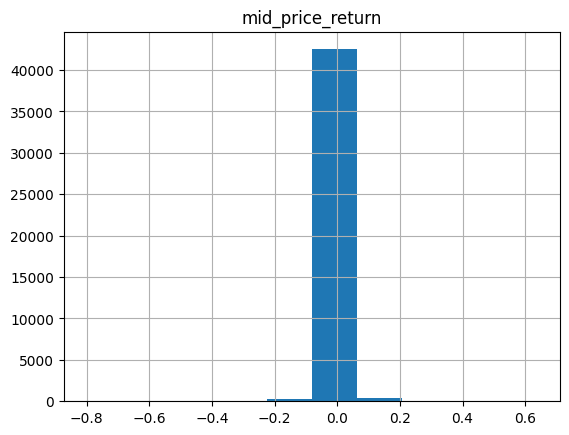

In [ ]:
df[['mid_price_return', 'mid_price_return_class']].hist()

In [ ]:
df[['mid_price_return', 'mid_price_return_class']].describe()

,mid_price_return
count,43198.000000
mean,0.000173
std,0.022040
min,-0.801187
25%,-0.004901
50%,0.000000
75%,0.005140
max,0.637820


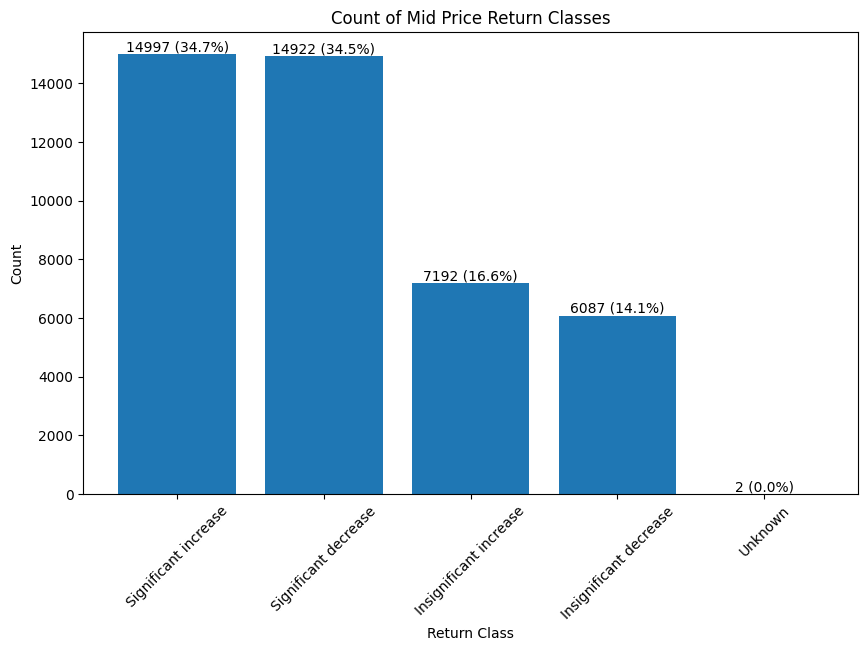

In [ ]:
# 분류된 데이터로 그래프 작업 진행
temp_counts = df['mid_price_return_class'].value_counts()

# 전체 개수 대비 비율 계산
total_count = temp_counts.sum()
percentages = (temp_counts / total_count) * 100

# 그래프 생성 및 개수, 퍼센티지 표시
plt.figure(figsize=(10, 6))
bars = plt.bar(temp_counts.index, temp_counts.values)

# 그래프 레이블 설정
plt.xlabel('Return Class')
plt.ylabel('Count')
plt.title('Count of Mid Price Return Classes')
plt.xticks(rotation=45)

# 각 막대 위에 개수 및 비율 표시
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)} ({percentage:.1f}%)',
             ha='center', va='bottom')

plt.show()

In [ ]:
# # insignificant한 데이터 추출
# df_with_insignificant = df.copy()

# # significant 데이터만 추출
# df = df[(df['mid_price_return_class'] == 'Significant increase') |
#         (df['mid_price_return_class'] == 'Significant decrease')]
# print(df.shape)

In [ ]:
# 특정 변수(1_min_return, 5_min_return)를 제외하고 데이터프레임에서 제거
df = df.drop(['1_min_return', '5_min_return'], axis=1)

# 수치형 데이터만 추출하여 NaN과 무한대 값 확인
numeric_df = df.select_dtypes(include=[np.number])

# NaN 값이 있는지 확인
print("NaN counts per column:")
print(df.isna().sum().any())

# 무한대 값이 있는지 확인
print("Infinite values counts per column:")
print(np.isinf(numeric_df).sum().any())

# NaN 또는 무한대 값이 있다면 제거
#df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


NaN counts per column:
True
Infinite values counts per column:
False


In [ ]:
# 종속변수 라벨을 2개의 클래스(0, 1)로 변환
label_mapping = {'Significant increase': 0, 'Significant decrease': 1,
                 'Insignificant increase': 2, 'Insignificant decrease': 3}

# 종속변수 설정
df['target_column'] = df['mid_price_return_class'].map(label_mapping)

# # 1. 먼저 학습(train)과 나머지(valid + test) 데이터를 나눕니다.
# train_data, temp_data = train_test_split(df, test_size=0.4, shuffle = False)

# # 2. 그 다음, 나머지 데이터(temp_data)를 검증(valid)과 테스트(test)로 나눕니다.
# valid_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle = False)

# # 결과 확인
# print(f"Train set size: {train_data.shape}")
# print(f"Validation set size: {valid_data.shape}")
# print(f"Test set size: {test_data.shape}")


In [ ]:
df['target_column'].value_counts()

,count
target_column,
0,14997
1,14922
2,7186
3,6087


In [ ]:
# df['target_column_2'] = df['target_column'].shift(30)
#df.iloc[:50][['target_column', 'target_column_2']]

In [ ]:
# df['target_column'] = df['target_column_2']
# df.drop(['target_column_2'], axis=1, inplace=True)
# df.dropna(inplace=True)

In [ ]:
# 시계열 데이터 분할 (예: 80% Train, 20% Validation, 20% Test)
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

# 제외할 피처들
drop_cols = ['false.2', '1_min_return_atbest', '5_min_return_atbest', 'target_column', 'mid_price', 'mid_price_diff', 'mid_price_return', 'mid_price_return_class', 'target_column']

X_train = train_data.drop(columns=drop_cols)
y_train = train_data['target_column']
X_test = test_data.drop(columns=drop_cols)
y_test = test_data['target_column']

# 결과 확인
print(f"Train set size: {train_data.shape}")
print(f"Test set size: {test_data.shape}")


Train set size: (34553, 88)
Test set size: (8639, 88)


In [ ]:
# XGBoost 분류기 초기화 및 학습
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy: 0.5452019909711773


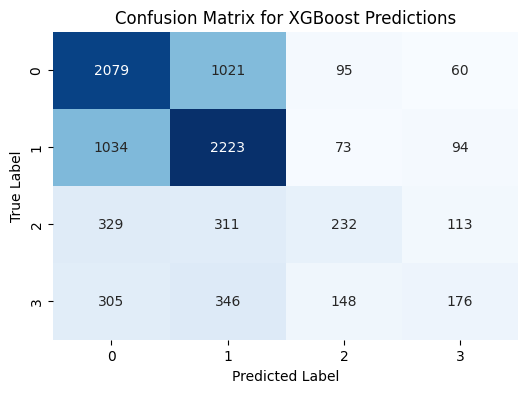

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.64      0.59      3255
           1       0.57      0.65      0.61      3424
           2       0.42      0.24      0.30       985
           3       0.40      0.18      0.25       975

    accuracy                           0.55      8639
   macro avg       0.49      0.43      0.44      8639
weighted avg       0.53      0.55      0.53      8639



In [ ]:
# 예측 및 평가
y_pred = model.predict(X_test)

# 1. 정확도
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 2. 혼동 행렬
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 그래프 출력
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost Predictions')
plt.show()

# 3. 분류 보고서 (정밀도, 재현율, F1 스코어 포함)
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# 4. AUC-ROC 점수
#roc_auc = roc_auc_score(y_valid, y_pred_prob)
#print("AUC-ROC Score:", roc_auc)

In [ ]:
@@@

SyntaxError: invalid syntax (<ipython-input-26-7e1bb4465bf8>, line 1)

In [ ]:

# 제외할 피처들
drop_cols = ['false.2', '1_min_return_atbest', '5_min_return_atbest', 'target_column', 'mid_price', 'mid_price_diff', 'mid_price_return', 'mid_price_return_class']

# 1. StandardScaler를 학습 데이터에 대해 학습 (fit)
scaler = StandardScaler()
train_features = train_data.drop(drop_cols, axis=1).values  # 종속변수를 제외한 피처만 선택
train_features_scaled = scaler.fit_transform(train_features)

# 2. 검증 및 테스트 세트에 동일한 스케일링 적용 (transform)
valid_features = valid_data.drop(drop_cols, axis=1).values
valid_features_scaled = scaler.transform(valid_features)

test_features = test_data.drop(drop_cols, axis=1).values
test_features_scaled = scaler.transform(test_features)

# 종속변수 라벨을 4개의 클래스(0, 1)로 변환
label_mapping = {'Significant increase': 1, 'Significant decrease': 0}
labels = df['mid_price_return_class'].map(label_mapping)

# 3. 종속변수(라벨)도 추출
train_labels = train_data['target_column'].values
valid_labels = valid_data['target_column'].values
test_labels = test_data['target_column'].values

# 4. 텐서로 변환
train_features_tensor = torch.tensor(train_features_scaled, dtype=torch.float32)
valid_features_tensor = torch.tensor(valid_features_scaled, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features_scaled, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)  # 분류 문제이므로 long 타입
valid_labels_tensor = torch.tensor(valid_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# 5. 결과 확인
print(f"Train features shape: {train_features_tensor.shape}")
print(f"Valid features shape: {valid_features_tensor.shape}")
print(f"Test features shape: {test_features_tensor.shape}")


In [ ]:

# 1. TensorDataset을 사용해 특징 텐서와 라벨 텐서를 결합
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
valid_dataset = TensorDataset(valid_features_tensor, valid_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

# 2. DataLoader로 데이터셋을 배치 단위로 로드
batch_size = 64  # 배치 사이즈를 설정 (필요에 따라 조정 가능)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)  # 검증과 테스트는 shuffle=False
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. DataLoader 확인
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(valid_loader)}")
print(f"Number of test batches: {len(test_loader)}")


### LSTM 모델

In [ ]:
# LSTM 모델 정의
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # 완전 연결 층

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # 초기 hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # 초기 cell state

        # LSTM 레이어를 통과
        out, _ = self.lstm(x, (h0, c0))

        # 마지막 time step의 출력값 사용
        out = out[:, -1, :]

        # 완전 연결층을 통과하여 로짓(logits) 출력
        out = self.fc(out)
        return out  # logits 반환


In [ ]:
# 모델 학습

# 하이퍼파라미터 설정
input_size = 80   # 입력 피처 수 (예: EMA, RSI 등)
hidden_size = 16  # LSTM 은닉 상태 크기
num_layers = 1  # LSTM 레이어 수
output_size = 2  # 2개의 클래스 (significant increase, significant decrease)
learning_rate = 0.00005

# 모델, 손실 함수 및 옵티마이저 설정
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

# 에포크별 손실 저장 리스트
train_losses = []
valid_losses = []

# 학습 루프
num_epochs = 200
best_valid_loss = float('inf')
best_epoch = 0
best_model_path = 'best_model.pth'  # 베스트 모델 저장 경로

for epoch in range(num_epochs):
    # 1. 훈련 단계
    model.train()
    train_loss = 0
    for features, labels in train_loader:  # train_loader는 학습 데이터를 위한 DataLoader입니다.
        features = features.unsqueeze(1)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # 2. 검증 단계
    model.eval()
    valid_loss = 0
    with torch.no_grad():  # 검증 단계에서는 역전파를 하지 않음
        for features, labels in valid_loader:  # valid_loader는 검증 데이터를 위한 DataLoader입니다.
            features = features.unsqueeze(1)
            outputs = model(features)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)

    # 검증 손실이 개선되었는지 확인 후 모델 저장
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoch
        torch.save(model.state_dict(), best_model_path)  # 모델 저장

    # 에포크별 손실 출력
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

# 최적의 에포크 출력
print(f'\nBest Epoch: {best_epoch+1}, Best Validation Loss: {best_valid_loss:.4f}')

# 4. 훈련 및 검증 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()


In [ ]:
# 베스트 모델 로드 및 테스트 데이터에서 예측 수행

# 모델 초기화 및 저장된 베스트 모델 로드
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load(best_model_path))  # 저장된 베스트 모델 로드
model.eval()  # 평가 모드로 전환

# 테스트 데이터에서 예측 수행
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:  # test_loader는 테스트 데이터를 위한 DataLoader입니다.
        features = features.unsqueeze(1)
        outputs = model(features)
        _, preds = torch.max(outputs, 1)  # 예측 클래스 선택

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. 분류 성능 보고서 출력 (정확도, 정밀도, 재현율, F1 스코어)
labels_set = [1, 0]  # 1: Significant increase, 0: Significant decrease
target_names = ['Significant increase', 'Significant decrease']  # 2개의 클래스만 사용

# Classification report 출력
report = classification_report(all_labels, all_preds, labels=labels_set, target_names=target_names, zero_division=0)
print(report)

# Accuracy 계산 및 출력
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# 2. 혼동 행렬 계산 및 시각화
cm = confusion_matrix(all_labels, all_preds, labels=labels_set)

# 혼동 행렬 히트맵 시각화 (x축 값 45도 회전)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xticks(rotation=45)  # x축 라벨 45도 회전
plt.title('Confusion Matrix Heatmap')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


### 실제 데이터에 적용
- insignificant increase, decrease도 적용

In [ ]:
df_with_insignificant

In [ ]:
df = df_with_insignificant
df

In [ ]:
# 특정 변수(1_min_return, 5_min_return)를 제외하고 데이터프레임에서 제거
df = df.drop(['1_min_return', '5_min_return'], axis=1)

# 수치형 데이터만 추출하여 NaN과 무한대 값 확인
numeric_df = df.select_dtypes(include=[np.number])

# NaN 값이 있는지 확인
print("NaN counts per column:")
print(df.isna().sum().any())

# 무한대 값이 있는지 확인
print("Infinite values counts per column:")
print(np.isinf(numeric_df).sum().any())

# NaN 또는 무한대 값이 있다면 제거
#df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


In [ ]:
# 종속변수 라벨을 2개의 클래스(0, 1)로 변환
label_mapping = {'Significant increase': 1,
                'Significant decrease': 0,
                'Insignificant increase': 0,
                'Insignificant decrease:': 0
                }

# 종속변수 설정
df['target_column'] = df['mid_price_return_class'].map(label_mapping)

# 1. 먼저 학습(train)과 나머지(valid + test) 데이터를 나눕니다.
train_data, temp_data = train_test_split(df, test_size=0.4, shuffle = False)

# 2. 그 다음, 나머지 데이터(temp_data)를 검증(valid)과 테스트(test)로 나눕니다.
valid_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle = False)

# 결과 확인
print(f"Train set size: {train_data.shape}")
print(f"Validation set size: {valid_data.shape}")
print(f"Test set size: {test_data.shape}")


In [ ]:

# 제외할 피처들
drop_cols = ['false.2', '1_min_return_atbest', '5_min_return_atbest', 'target_column', 'mid_price', 'mid_price_diff', 'mid_price_return', 'mid_price_return_class']

# 1. StandardScaler를 학습 데이터에 대해 학습 (fit)
scaler = StandardScaler()
train_features = train_data.drop(drop_cols, axis=1).values  # 종속변수를 제외한 피처만 선택
train_features_scaled = scaler.fit_transform(train_features)

# 2. 검증 및 테스트 세트에 동일한 스케일링 적용 (transform)
valid_features = valid_data.drop(drop_cols, axis=1).values
valid_features_scaled = scaler.transform(valid_features)

test_features = test_data.drop(drop_cols, axis=1).values
test_features_scaled = scaler.transform(test_features)

# 종속변수 라벨을 2개의 클래스(0, 1)로 변환
label_mapping = {'Significant increase': 1,
                'Significant decrease': 0,
                'Insignificant increase': 0,
                'Insignificant decrease:': 0
                }
labels = df['target_column'].map(label_mapping)

# 3. 종속변수(라벨)도 추출
train_labels = train_data['target_column'].values
valid_labels = valid_data['target_column'].values
test_labels = test_data['target_column'].values

# 4. 텐서로 변환
train_features_tensor = torch.tensor(train_features_scaled, dtype=torch.float32)
valid_features_tensor = torch.tensor(valid_features_scaled, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features_scaled, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)  # 분류 문제이므로 long 타입
valid_labels_tensor = torch.tensor(valid_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# 5. 결과 확인
print(f"Train features shape: {train_features_tensor.shape}")
print(f"Valid features shape: {valid_features_tensor.shape}")
print(f"Test features shape: {test_features_tensor.shape}")


In [ ]:

# 1. TensorDataset을 사용해 특징 텐서와 라벨 텐서를 결합
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
valid_dataset = TensorDataset(valid_features_tensor, valid_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

# 2. DataLoader로 데이터셋을 배치 단위로 로드
batch_size = 64  # 배치 사이즈를 설정 (필요에 따라 조정 가능)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)  # 검증과 테스트는 shuffle=False
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. DataLoader 확인
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(valid_loader)}")
print(f"Number of test batches: {len(test_loader)}")


In [ ]:
# 베스트 모델 로드 및 테스트 데이터에서 예측 수행

# 모델 초기화 및 저장된 베스트 모델 로드
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load(best_model_path))  # 저장된 베스트 모델 로드
model.eval()  # 평가 모드로 전환

# 테스트 데이터에서 예측 수행
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:  # test_loader는 테스트 데이터를 위한 DataLoader입니다.
        features = features.unsqueeze(1)
        outputs = model(features)
        _, preds = torch.max(outputs, 1)  # 예측 클래스 선택

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. 분류 성능 보고서 출력 (정확도, 정밀도, 재현율, F1 스코어)
labels_set = [1, 0]  # 1: Significant increase, 0: Significant decrease
target_names = ['Significant increase', 'Significant decrease']  # 2개의 클래스만 사용

# Classification report 출력
report = classification_report(all_labels, all_preds, labels=labels_set, target_names=target_names, zero_division=0)
print(report)

# Accuracy 계산 및 출력
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# 2. 혼동 행렬 계산 및 시각화
cm = confusion_matrix(all_labels, all_preds, labels=labels_set)

# 혼동 행렬 히트맵 시각화 (x축 값 45도 회전)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xticks(rotation=45)  # x축 라벨 45도 회전
plt.title('Confusion Matrix Heatmap')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


- Precision (정밀도):

정밀도는 모델이 해당 클래스로 예측한 값 중 실제로 맞은 비율입니다.
예를 들어, "Significant increase" 클래스에 대해 모델이 98%의 정밀도를 보였다는 것은, 모델이 이 클래스로 예측한 값 중 98%가 실제로 맞았다는 의미입니다.
하지만 "Significant decrease" 클래스는 데이터에 등장하지 않아서 정밀도가 0.00으로 표시되었습니다.

- Recall (재현율):

재현율은 실제로 해당 클래스에 속한 데이터 중에서 모델이 올바르게 예측한 비율입니다.
예를 들어, "Insignificant increase" 클래스에 대한 재현율이 0.92라는 것은, 실제로 "Insignificant increase"에 속한 데이터 중 92%를 모델이 정확히 맞췄다는 의미입니다.
"Significant increase" 클래스의 재현율이 0.01이라는 것은, 이 클래스에 속한 실제 데이터 중 1%만 모델이 맞췄다는 의미입니다.

- F1-score:

F1 스코어는 정밀도와 재현율의 조화평균으로, 두 지표를 종합적으로 평가하는 지표입니다. 정밀도와 재현율 사이의 균형을 중요시할 때 유용합니다.
예를 들어, "Insignificant increase" 클래스의 F1 스코어가 0.84라는 것은, 정밀도와 재현율이 적절히 균형을 이뤘음을 의미합니다.

- Support:

Support는 각 클래스에 실제로 속한 데이터의 개수입니다.
예를 들어, "Insignificant increase" 클래스는 241,234개의 데이터 포인트를 가지고 있다는 것을 의미합니다.

- Micro avg (마이크로 평균):

마이크로 평균은 전체 데이터에서의 정밀도, 재현율, F1 스코어를 계산합니다. 이는 각 클래스의 데이터 개수를 고려하지 않고, 전체 데이터를 한 번에 평가하는 방식입니다.
마이크로 평균 77%는 모든 클래스의 데이터를 합쳐서 모델이 77%의 정확도를 보였음을 의미합니다.

- Macro avg (매크로 평균):

매크로 평균은 각 클래스의 정밀도, 재현율, F1 스코어의 평균을 단순히 계산한 것입니다. 이는 클래스별 데이터 비율을 고려하지 않기 때문에, 클래스 간 불균형이 있는 경우 잘못된 평가가 나올 수 있습니다.
예를 들어, "Significant decrease" 클래스처럼 데이터가 없는 클래스는 성능이 0으로 평가되며, 이러한 클래스들도 평균에 포함되기 때문에 성능이 낮아집니다.

- Weighted avg (가중 평균):

가중 평균은 각 클래스의 정밀도, 재현율, F1 스코어를 해당 클래스의 데이터 개수에 비례하여 평균을 계산한 것입니다. 즉, 클래스의 데이터가 많을수록 해당 클래스의 성능이 평균에 더 큰 영향을 줍니다.
Weighted 평균 77%는 실제 데이터 비율에 따라 가중치를 부여하여 계산한 성능입니다. 이 값은 전체적으로 모델이 77%의 정확도를 가지고 있음을 보여줍니다.